In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

import tqdm.notebook as tq

import gc


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, jaccard_score
import itertools

from PIL import Image
from numpy import asarray
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.1


In [2]:
import shutil

In [3]:
import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.0 (Tesla P100-PCIE-16GB)


In [4]:
!git clone https://github.com/ultralytics/yolov5.git  

Cloning into 'yolov5'...
remote: Enumerating objects: 15978, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 15978 (delta 89), reused 117 (delta 75), pack-reused 15831
Receiving objects: 100% (15978/15978), 14.61 MiB | 19.60 MiB/s, done.
Resolving deltas: 100% (10958/10958), done.


In [5]:
os.chdir('/kaggle/working/yolov5')
%pip install -qr requirements.txt 
os.chdir('/kaggle/working/')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
opentelemetry-api 1.17.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 5.2.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
raft-dask 23.4.1 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pwd

/kaggle/working


In [6]:
import random
seed_val = 101
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [7]:
# Yolo setup:
NUM_EPOCHS = 80
BATCH_SIZE = 32
IMAGE_SIZE = 512 # Yolo will automatically resize the input images to this size.

# This is the fold that Yolo is trained on
CHOSEN_FOLD = 0

NUM_FOLDS = 5

NUM_CORES = os.cpu_count()
NUM_CORES

2

In [9]:
#shutil.copytree('../input/v2-balloon-detection-dataset/yolov5', '/kaggle/working/yolov5')

In [8]:
df_train = pd.read_csv("/kaggle/input/leftimg8bit-bb/leftImg8bit_with_bb/training_data.csv")

In [9]:
df_train.drop(columns=df_train.columns[0], axis=1, inplace=True)

In [26]:
df_train

path  \
0      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
1      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
2      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
3      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
4      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
...                                                  ...   
22717  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22718  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22719  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22720  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22721  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   

                                             coordinates  class  
0      {'x': 725, 'y': 390, 'width': 215, 'height': 126}      0  
1      {'x': 1341, 'y': 364, 'width': 376, 'height': ...      0  
2      {'x': 1630, 'y': 378, 'width': 372, 'height': ...      0  
3      {'x': 1338, 'y': 395, 'width': 100, 'height': ...      0  
4        {'x': 561, 'y': 435, 'width': 44, 'height': 51}      1  
...                                                  ...    ...  
22717   {'x': 1008, 'y': 433, 'width': 70, 'height': 58}      0  
22718   {'x': 1057, 'y': 425, 'width': 94, 'height': 78}      0  
22719   {'x': 1039, 'y': 440, 'width': 39, 'height': 57}      0  
22720    {'x': 868, 'y': 447, 'width': 22, 'height': 27}      0  
22721  {'x': 698, 'y': 352, 'width': 144, 'height': 144}      3  

[22722 rows x 3 columns]

In [10]:
df_train = df_train.rename(columns={'class': 'target'})

In [11]:
df_train

path  \
0      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
1      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
2      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
3      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
4      /kaggle/input/leftimg8bit/leftImg8bit/train/du...   
...                                                  ...   
22717  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22718  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22719  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22720  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   
22721  /kaggle/input/leftimg8bit/leftImg8bit/train/ul...   

                                             coordinates  target  
0      {'x': 725, 'y': 390, 'width': 215, 'height': 126}       0  
1      {'x': 1341, 'y': 364, 'width': 376, 'height': ...       0  
2      {'x': 1630, 'y': 378, 'width': 372, 'height': ...       0  
3      {'x': 1338, 'y': 395, 'width': 100, 'height': ...       0  
4        {'x': 561, 'y': 435, 'width': 44, 'height': 51}       1  
...                                                  ...     ...  
22717   {'x': 1008, 'y': 433, 'width': 70, 'height': 58}       0  
22718   {'x': 1057, 'y': 425, 'width': 94, 'height': 78}       0  
22719   {'x': 1039, 'y': 440, 'width': 39, 'height': 57}       0  
22720    {'x': 868, 'y': 447, 'width': 22, 'height': 27}       0  
22721  {'x': 698, 'y': 352, 'width': 144, 'height': 144}       3  

[22722 rows x 3 columns]

In [11]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=101)

In [12]:
print(df_train.shape)
print(df_val.shape)

(18177, 3)
(4545, 3)


In [13]:
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [20]:
!rm -rf /kaggle/working/yolov5/base_dir

In [14]:
base_dir = 'base_dir'
os.mkdir(base_dir)

# Now we create folders inside 'base_dir':

# base_dir

    # images
        # train
        # validation

    # labels
        # train
        # validation

# images
images = os.path.join(base_dir, 'images')
os.mkdir(images)

# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)

# Inside each folder we create seperate folders for each class

# create new folders inside images
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)


# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)

In [15]:
!ls

CITATION.cff	 README.zh-CN.md  data	      models		train.py
CONTRIBUTING.md  base_dir	  detect.py   requirements.txt	tutorial.ipynb
LICENSE		 benchmarks.py	  export.py   segment		utils
README.md	 classify	  hubconf.py  setup.cfg		val.py


In [16]:
os.listdir('base_dir/images')

['train', 'validation']

In [17]:
!tree base_dir

base_dir
├── images
│   ├── train
│   └── validation
└── labels
    ├── train
    └── validation

6 directories, 0 files


In [18]:
os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [19]:
df_train.head()

path  \
11792  /kaggle/input/leftimg8bit/leftImg8bit/train/ha...   
2804   /kaggle/input/leftimg8bit/leftImg8bit/train/tu...   
12955  /kaggle/input/leftimg8bit/leftImg8bit/train/mo...   
10890  /kaggle/input/leftimg8bit/leftImg8bit/train/ha...   
3718   /kaggle/input/leftimg8bit/leftImg8bit/train/er...   

                                            coordinates  target  
11792   {'x': 727, 'y': 406, 'width': 41, 'height': 32}       0  
2804   {'x': 588, 'y': 397, 'width': 136, 'height': 73}       0  
12955   {'x': 415, 'y': 460, 'width': 30, 'height': 22}       0  
10890  {'x': 1070, 'y': 378, 'width': 95, 'height': 78}       0  
3718   {'x': 1360, 'y': 391, 'width': 36, 'height': 21}       0

In [27]:
#df_train["path"] = df_train["path"].str.replace("/kaggle/input/leftimg8bit/leftImg8bit/train/")

In [22]:
df_train.head()

path  \
11792  /kaggle/input/leftimg8bit/leftImg8bit/train/ha...   
2804   /kaggle/input/leftimg8bit/leftImg8bit/train/tu...   
12955  /kaggle/input/leftimg8bit/leftImg8bit/train/mo...   
10890  /kaggle/input/leftimg8bit/leftImg8bit/train/ha...   
3718   /kaggle/input/leftimg8bit/leftImg8bit/train/er...   

                                            coordinates  target  
11792   {'x': 727, 'y': 406, 'width': 41, 'height': 32}       0  
2804   {'x': 588, 'y': 397, 'width': 136, 'height': 73}       0  
12955   {'x': 415, 'y': 460, 'width': 30, 'height': 22}       0  
10890  {'x': 1070, 'y': 378, 'width': 95, 'height': 78}       0  
3718   {'x': 1360, 'y': 391, 'width': 36, 'height': 21}       0

In [20]:
import json

coor = df_train["coordinates"].iloc[0]
coor = coor.replace("'", '"')
coor = json.loads(str(coor))
print(coor)
x = coor['x']
print(x)

{'x': 727, 'y': 406, 'width': 41, 'height': 32}
727


In [21]:
# Iterate through each row in the dataframe

# We run the function below separately for
# the train and val sets.
# Remember that each image gets it's own text file
# containing the info for all bboxes on that image.

# For each image:
# 1- get the info for each bounding box
# 2- write the bounding box info to a txt file
# 3- save the txt file in the correct folder
# 4- copy the image to the correct folder


# This maybe wrong
image_width = 2048
image_height = 1024

def process_data_for_yolo(df, data_type='train'):

    for _, row in tq.tqdm(df.iterrows(), total=len(df)):
        
        path = row['path']
        bbox_list = row['coordinates']
        
        bbox_list = bbox_list.replace("'", '"')
        bbox_list = json.loads(str(bbox_list))
 
        
        # Convert into the Yolo input format
        # ...................................
        

        yolo_data = []
        
        x = int(bbox_list['x'])
        y = int(bbox_list['y'])
        width = int(bbox_list['width'])
        height = int(bbox_list['height'])
        
        x_center = x + (width/2)
        y_center = y + (height/2)
        
        x_center = x_center/image_width
        y_center = y_center/image_height
        bbox_w = width/image_width
        bbox_h = height/image_height
        
        class_id = row['target']
        
        yolo_list = [class_id, x_center, y_center, bbox_w, bbox_h]
        
        yolo_data.append(yolo_list)

        # convert to nump array
        yolo_data = np.array(yolo_data)


        # save the text file
        image_id = path.replace("/", "_")
        image_label_id = image_id.replace(".png", "")
        np.savetxt(os.path.join('yolov5/base_dir', 
                    f"labels/{data_type}/{image_label_id}.txt"),
                    yolo_data, 
                    fmt=["%d", "%f", "%f", "%f", "%f"]
                    ) # fmt means format the columns

        # Copy the image to images
        shutil.copyfile(
            path,
            os.path.join('yolov5/base_dir', f"images/{data_type}/{image_id}")
        )
        

# Call the function    
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

  0%|          | 0/18177 [00:00<?, ?it/s]

  0%|          | 0/4545 [00:00<?, ?it/s]

In [23]:
# Check that the files have been created

print(len(os.listdir('yolov5/base_dir/images/train')))
print(len(os.listdir('yolov5/base_dir/images/validation')))

print(len(os.listdir('yolov5/base_dir/labels/train')))
print(len(os.listdir('yolov5/base_dir/labels/validation')))

2880
2159
2880
2159


In [24]:
text_file_list = os.listdir('yolov5/base_dir/labels/train')

text_file = text_file_list[0]

text_file

'_kaggle_input_leftimg8bit_leftImg8bit_train_aachen_aachen_000071_000019_leftImg8bit.txt'

In [30]:
! cat 'yolov5/base_dir/labels/train/_kaggle_input_leftimg8bit_leftImg8bit_train_jena_jena_000053_000019_leftImg8bit.txt'

0 1281.000000 411.000000 438.000000 145.000000


In [25]:
! cat 'yolov5/base_dir/labels/train/_kaggle_input_leftimg8bit_leftImg8bit_train_jena_jena_000053_000019_leftImg8bit.txt'

0 0.732422 0.472168 0.213867 0.141602


In [26]:
yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 9,                             # number of classes
            'names': ['car', 'bicycle', 'train', 'bus', 'motorcycle', 'truck', 'trailer', 'tunnel', 'dynamic']}                # list of label names

In [27]:
# Create the yaml file called my_data.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [28]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['hubconf.py',
 'benchmarks.py',
 'README.zh-CN.md',
 '.git',
 'classify',
 '.gitattributes',
 'data',
 'utils',
 'LICENSE',
 'setup.cfg',
 'README.md',
 'my_data.yaml',
 'tutorial.ipynb',
 'train.py',
 '.gitignore',
 'export.py',
 'CONTRIBUTING.md',
 'requirements.txt',
 'segment',
 'base_dir',
 'detect.py',
 '.pre-commit-config.yaml',
 'val.py',
 'models',
 'CITATION.cff',
 '.github',
 '.dockerignore']

In [29]:
# Display the contents of the yaml file

! cat 'yolov5/my_data.yaml'

names:
- car
- bicycle
- train
- bus
- motorcycle
- truck
- trailer
- tunnel
- dynamic
nc: 9
train: base_dir/images/train
val: base_dir/images/validation


In [30]:
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [ ]:
!WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data my_data.yaml --weights runs/train/exp2/weights/best.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=runs/train/exp2/weights/best.pt, cfg=, data=my_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005

In [33]:
 os.listdir('runs/train/')

['exp2', 'exp']

In [36]:
exp_list = os.listdir('runs/train/')
exp = exp_list[0]

exp

'exp2'

In [37]:
os.listdir(f'runs/train/{exp}')

['R_curve.png',
 'P_curve.png',
 'events.out.tfevents.1686282726.0c1fefc216ec.6264.0',
 'hyp.yaml',
 'train_batch0.jpg',
 'labels_correlogram.jpg',
 'results.png',
 'results.csv',
 'F1_curve.png',
 'labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch0_pred.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg',
 'train_batch2.jpg',
 'weights',
 'train_batch1.jpg',
 'PR_curve.png',
 'val_batch0_labels.jpg',
 'confusion_matrix.png',
 'val_batch1_labels.jpg',
 'opt.yaml']

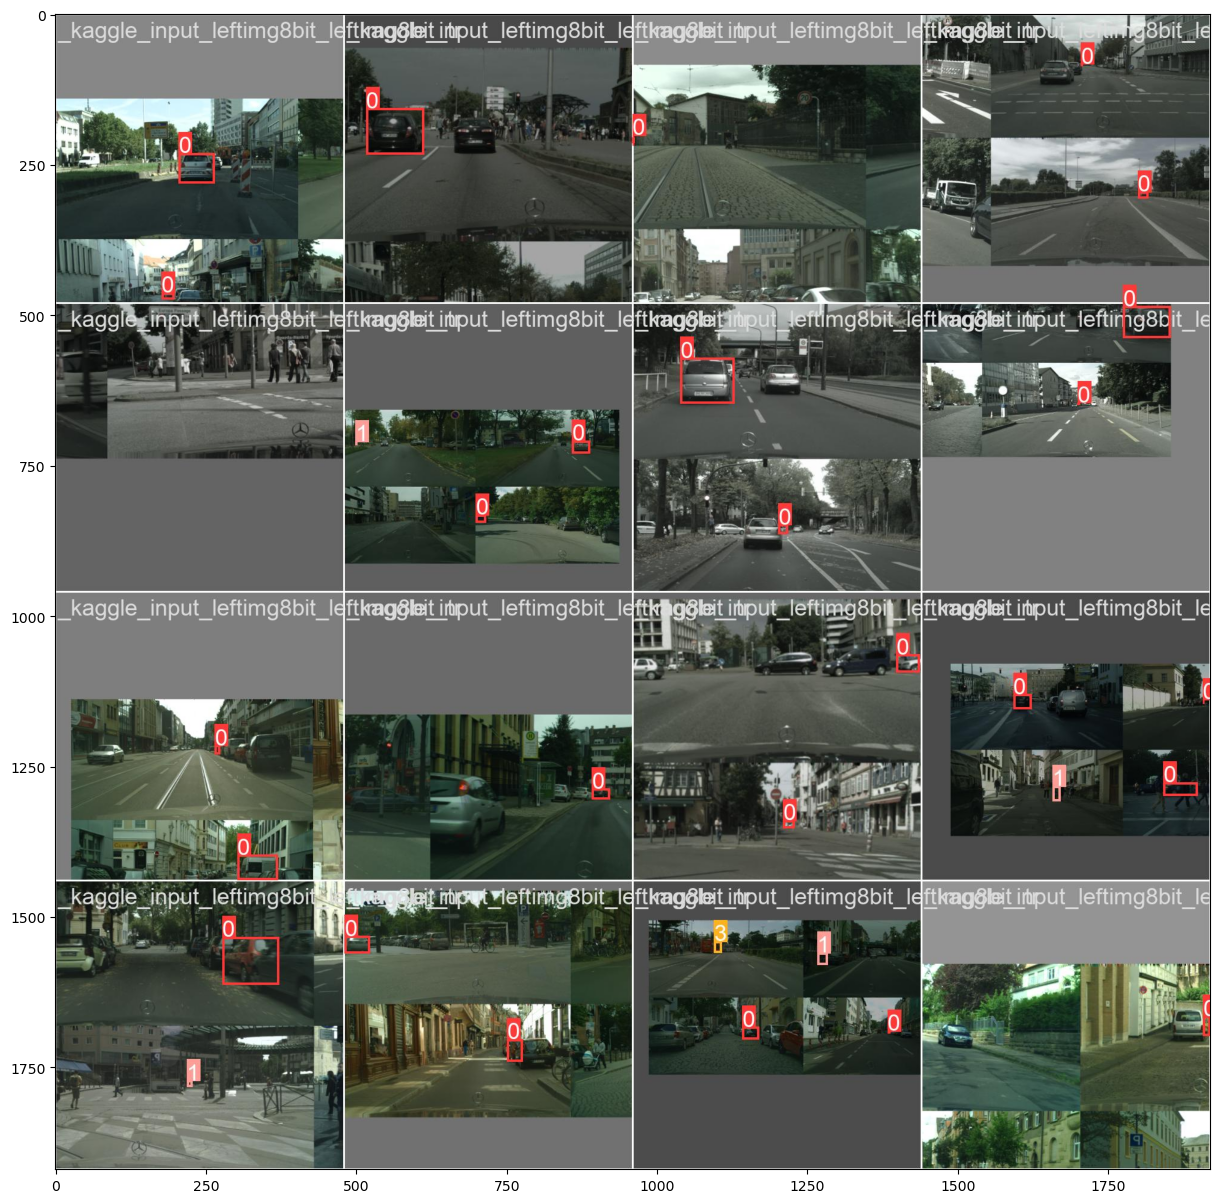

In [38]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/train_batch0.jpg'))

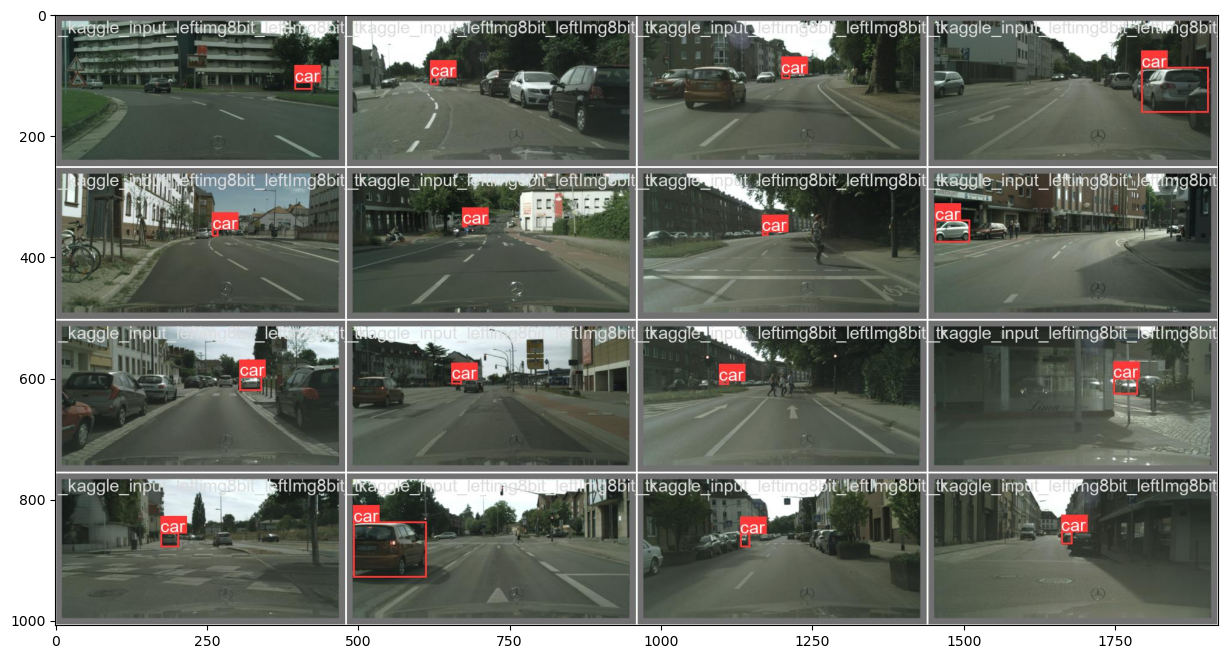

In [40]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch0_labels.jpg'))

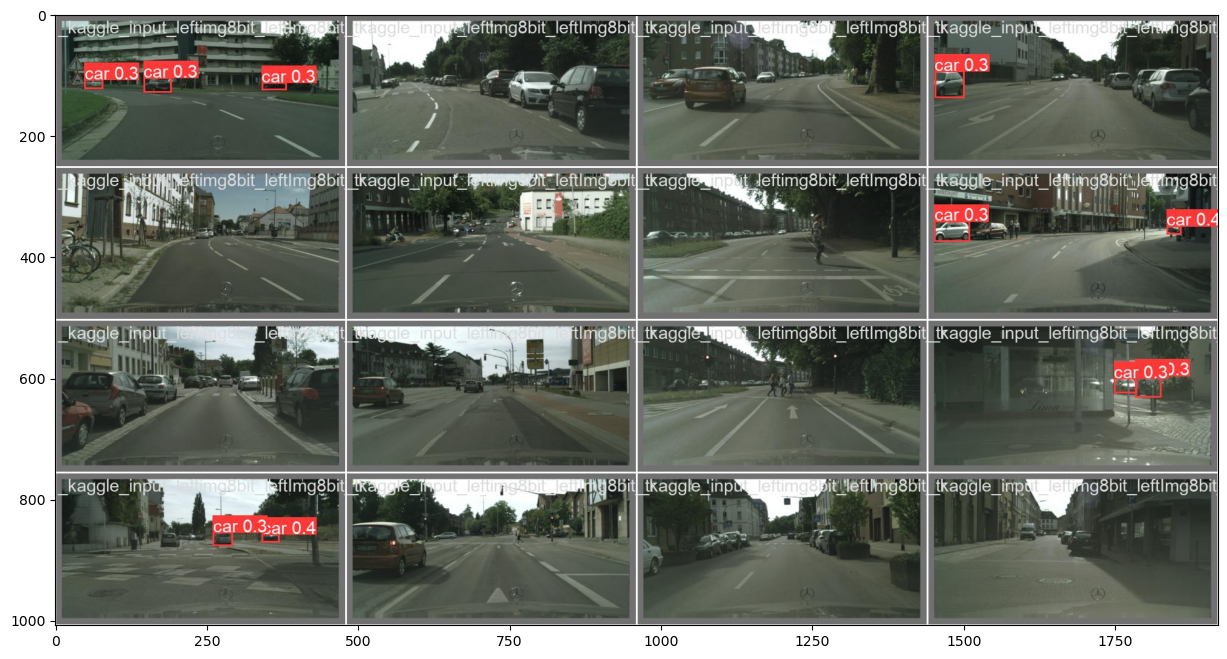

In [42]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch0_pred.jpg'))

In [43]:
os.listdir(f'runs/train/{exp}/weights')

['best.pt', 'last.pt']

In [46]:
shutil.copyfile(
            "runs/train/exp/weights/best.pt",
            "/kaggle/working/bestmodel_0.pt"
        )

'/kaggle/working/bestmodel_0.pt'

In [47]:
exp_list = os.listdir('runs/train/')
exp = exp_list[1]

exp

'exp'

In [48]:
os.listdir(f'runs/train/{exp}')

['hyp.yaml',
 'train_batch0.jpg',
 'labels_correlogram.jpg',
 'results.csv',
 'events.out.tfevents.1686272400.0c1fefc216ec.524.0',
 'labels.jpg',
 'train_batch2.jpg',
 'weights',
 'train_batch1.jpg',
 'opt.yaml']